In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

C:\Users\LegendLeo\AppData\Local\Temp\ipykernel_17028\1431380321.py:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


## Data Loading
Define the dataloader arguments and set up the device to use for computations.

In [1]:
import tonic
from tonic import CachedDataset

# 加载N-MNIST数据集
dataset = CachedDataset(tonic.datasets.NMNIST(save_to='./datasets'), cache_path='./cache')

def events_to_spike_tensor(events, time_window, img_size=(28, 28)):
    """
    将事件数据转换为脉冲张量
    :param events: 事件数据，形状为 (N, 4)，其中 N 是事件数量，4 表示 (x, y, t, p)
    :param time_window: 时间窗口大小
    :param img_size: 图像大小，默认为 (28, 28)
    :return: 脉冲张量，形状为 (time_window, 1, img_size[0], img_size[1])
    """
    spike_tensor = torch.zeros(time_window, 1, img_size[0], img_size[1])
    for event in events:
        x, y, t, p = event
        if p == 1:  # 只处理正极性事件
            time_step = int(t // time_window)
            spike_tensor[time_step, 0, y, x] = 1.0
    return spike_tensor

# 示例：加载一个样本并转换为脉冲张量
sample, target = dataset[0]
events = sample.numpy()  # 假设事件数据是numpy数组
time_window = 100  # 时间窗口大小
spike_tensor = events_to_spike_tensor(events, time_window)

Extracting ./datasets\NMNIST\train.zip to ./datasets\NMNIST


  0%|          | 0/1011893601 [00:00<?, ?it/s]

C:\Users\LegendLeo\AppData\Local\Temp\ipykernel_5064\68902607.py:5: DeprecationWarning: CachedDataset is deprecated and will be removed in a future release. It currently points to DiskCachedDataset to distinguish it from MemoryCachedDataset. Documentation available under https://tonic.readthedocs.io/en/latest/reference/data_classes.html#caching
  dataset = CachedDataset(tonic.datasets.NMNIST(save_to='./datasets'), cache_path='./cache')


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [2]:
# dataloader arguments
batch_size = 128
data_path='./datasets/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Data Transformation and Loading
Define a transform to resize and normalize the MNIST images, and create DataLoader objects for the training and test sets.

In [3]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## Define the Network
The convolutional network architecture to be used is: 12C5-MP2-64C5-MP2-1024FC10
- 12C5: 5x5 convolutional kernel with 12 filters
- MP2: 2x2 max-pooling layer
- 64C5: 5x5 convolutional kernel with 64 filters
- MP2: 2x2 max-pooling layer
- 1024FC10: Fully connected layer that maps 1024 neurons to 10 outputs

In [4]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

## Network Architecture
Define the spiking neural network architecture using PyTorch modules.

In [5]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(64*4*4, 10)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        cur1 = F.max_pool2d(self.conv1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)

        cur3 = self.fc1(spk2.view(batch_size, -1))
        spk3, mem3 = self.lif3(cur3, mem3)
        return spk3, mem3

## Initialize the Network
Set up the network with the defined layers and transfer it to the device (CPU/GPU).

In [6]:
#  Initialize Network
net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 64, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(64*4*4, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

## Forward Pass
Perform a forward pass through the network to initialize the network and ensure the layers are correctly set up.

In [7]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

for step in range(num_steps):
    spk_out, mem_out = net(data)

## Forward Pass Function
Define a function to perform the forward pass for a specified number of time steps.

In [8]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

## Loss Function
Define the loss function to be used for training the SNN.

In [9]:
# already imported snntorch.functional as SF
loss_fn = SF.ce_rate_loss()

## Batch Accuracy
Define a function to compute the accuracy over the entire dataset.

In [10]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

## Evaluate Test Accuracy
Compute the accuracy on the test set using the defined batch accuracy function.

In [11]:
test_acc = batch_accuracy(test_loader, net, num_steps)

print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

The total accuracy on the test set is: 9.80%


## Training the Network
Set up the optimizer and train the network over multiple epochs, tracking the loss and accuracy.

In [12]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 50 == 0:
          with torch.no_grad():
              net.eval()

              # Test set forward pass
              test_acc = batch_accuracy(test_loader, net, num_steps)
              print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
              test_acc_hist.append(test_acc.item())

        counter += 1

Iteration 0, Test Acc: 9.82%

Iteration 50, Test Acc: 83.72%

Iteration 100, Test Acc: 93.53%

Iteration 150, Test Acc: 93.24%

Iteration 200, Test Acc: 96.76%

Iteration 250, Test Acc: 96.53%

Iteration 300, Test Acc: 96.41%

Iteration 350, Test Acc: 96.49%

Iteration 400, Test Acc: 97.35%

Iteration 450, Test Acc: 97.63%



## Plot Results
Plot the accuracy on the test set over the training epochs.

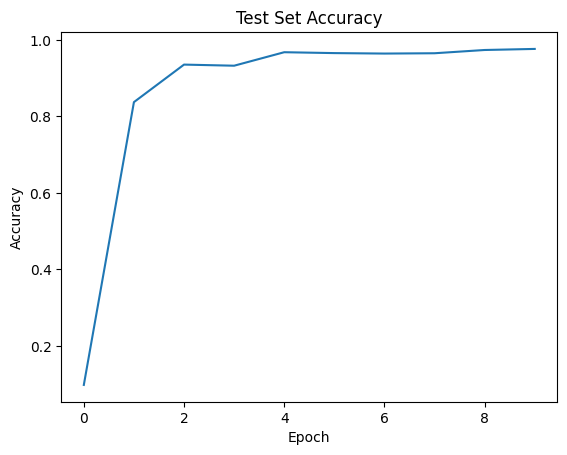

In [13]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()